In [19]:
# 安装依赖
!pip install imageio

#  k近邻 (k-Nearest Neighbor, kNN)分类器

手动完成需要完成的部分(包括输入输出)。

kNN分类包括两个阶段：

- 在训练阶段，分类器输入训练数据并且记住它们；
- 在测试阶段，kNN通过比对所有的训练集图像，采取k个最相似的训练集图像的标签来分类每个测试图像。
- 用交叉验证来决定k值

在此次作业你会通过实现了解最简单的图像分类pipeline，交叉验证和如何向量化你的代码。

In [20]:
# 运行项目的startup code

import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# jupyter book的magic functions，使绘图内嵌而不是新建窗口
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# jupyter book的magic functions，使得重新载入python模块
# 详情查看 http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# 读取CIFAR-10数据集，记得确认是否已经下载数据集、解压缩并放到以下路径.
# 若未下载数据集，可执行utils/datasets/get_datasets.sh脚本下载
cifar10_dir = 'utils/datasets/cifar-10-batches-py'

# 清空变量防止多次读取数据 (可能造成内存不够)
try:
   del X_train, y_train
   del X_test, y_test
   print('清除之前读取的数据')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 检查训练集测试集大小是否正确
print('训练集数据大小: ', X_train.shape)
print('训练集标签尺寸: ', y_train.shape)
print('测试集数据大小: ', X_test.shape)
print('测试集标签尺寸: ', y_test.shape)

清除之前读取的数据
训练集数据大小:  (50000, 32, 32, 3)
训练集标签尺寸:  (50000,)
测试集数据大小:  (10000, 32, 32, 3)
测试集标签尺寸:  (10000,)


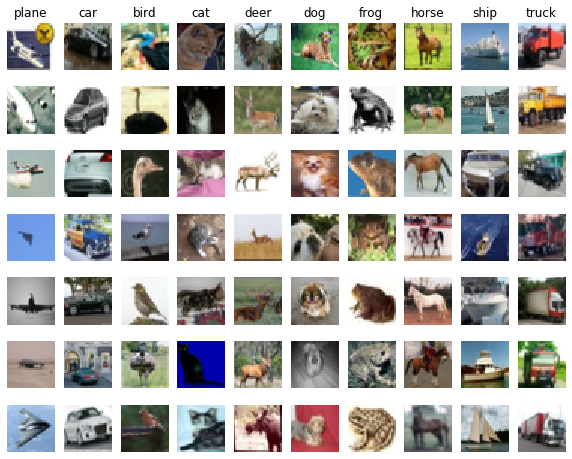

In [22]:
# 可视化一些数据集里的数据。
# 展示了不同类别的一些图像。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [23]:
# 把数据整理成更方便高效率进行处理的形式。
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 把数据集整理成矩阵(行为样本数，列为单张32x32像素图片展平成一维向量（32x32x3=3072）)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [24]:
from utils.classifiers import KNearestNeighbor

# 创建kNN分类器的实例
# 对kNN分类器来说，只是简单地保存了数据并且没有做进一步处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

接下来需要对使用测试数据kNN分类器进行分类。包括以下两个步骤：

1. 首先我们需要计算所有测试集图像和测试集图像的距离。
2. 通过距离可以找到k个最近的训练集样本并通过多数投票（vote）决定测试图像的类别。（结合该前提，可以自行搜索维数诅咒）

让我们从计算所有训练集和测试集图像的距离开始。假设有**Ntr** 个训练集图像和 **Nte** 个测试集图像, 这个阶段会计算出 **Nte x Ntr** 矩阵，第(i,j)个元素是第i个测试图像和第j个训练图像的距离。

**注意：需要自己实现距离计算函数而不能使用类似np.linalg.norm()的内置范数函数。**

首先，打开 `utils/classifiers/k_nearest_neighbor.py` 并且实现 `compute_distances_two_loops` 函数，它使用了一个低效的双重循环来计算每个测试样本和训练样本对的距离来生成距离矩阵。

In [25]:
# 打开 utils/classifiers/k_nearest_neighbor.py 并且实现 compute_distances_two_loops 函数。

# 测试你的实现:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


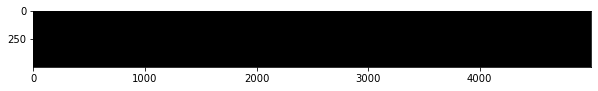

In [26]:
# 可视化距离矩阵：每行是一个简单的测试样本和它与每个训练样本的距离。
plt.imshow(dists, interpolation='none')
plt.show()

**问题 1**

观察距离矩阵里的结构化模式特征，那些行和列的值颜色会更亮一些。(黑色表示距离小，距离越大亮度越大。)

- 什么原因导致了某些行更亮呢?
- 什么原因导致了某些列更亮呢?

$\color{blue}{\textit 你的答案:}$ *fill this in.*



In [27]:
# 实现函数 predict_labels 并运行以下代码:
# 我们使用 k = 1 (取距离最近的邻居).
y_test_pred = classifier.predict_labels(dists, k=1)

# 计算并输出部分正确分类的样本
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


结果应该会有大概 `27%` 的精度. 选择更大的 `k`值, 比如 `k = 5`:

In [28]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


结果会比 `k = 1`的精度略高一些。

**问题 2**

我们也可以使用诸如 L1 distance 的距离函数。
对所有图片 $I_k$ 在 $(i,j)$ 位置上的像素值 $p_{ij}^{(k)}$取均值， $\mu$ 为 $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
，并且所有图片像素级别的均值$\mu_{ij}$ 为
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
通用标准差 $\sigma$ 和像素级别的标准差 $\sigma_{ij}$ 也是类似的定义。

下列哪个预处理步骤不会改变使用L1范数距离的kNN分类器的性能？
1. 减去均值 $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. 减去像素级均值 $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. 减去均值 $\mu$ 并且除与标准差 $\sigma$.
4. 减去像素级均值 $\mu_{ij}$ 并且除与像素级标准差 $\sigma_{ij}$.
5. 旋转图片坐标轴.

$\color{blue}{\textit 你的答案:}$


$\color{blue}{\textit 你的解释:}$


In [29]:
# 让我们通过单层循环和部分向量化来加速距离矩阵的计算。使用以下代码：
dists_one = classifier.compute_distances_one_loop(X_test)

# 为了保证我们的向量化实现是正确的，必须确保其与原生的实现结果保持一致。有非常多的方式来决定两个
# 矩阵是否相似；最简单的一种是使用F范数（Frobenius norm）。F范数是矩阵所有元素差异总和的开方
# 根；也就是说，可以把这些矩阵reshape成向量再计算它们的欧式距离。
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('单词循环的差异: %f' % (difference, ))
# 因为浮点数的固有误差（使用10进制科学计数法与2进制转换会有误差） 因此不可能完全相等
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

单词循环的差异: 0.000000
Good! The distance matrices are the same


In [30]:
# 现在在 compute_distances_no_loops 函数中实现完全向量化的版本
dists_two = classifier.compute_distances_no_loops(X_test)

# 检查与先前实现版本的差异:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('无循环版本的差异为: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

无循环版本的差异为: 0.000000
Good! The distance matrices are the same


In [31]:
# 比对不同实现的速度差异
def time_function(f, *args):
    """
    通过可变参数调用函数f并返回执行的时间。
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('两层循环版本执行了 %f 秒' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('单层循环版本执行了 %f 秒' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('无循环版本执行了 %f 秒' % no_loop_time)

# 可以看到完全向量化版本实现得到了明显更快的速度!

# 注意:取决于你使用的机器差异，你可能不会看到两层循环到单层循环速度的提升，甚至可能速度会下降一些。 =

两层循环版本执行了 0.045998 秒
单层循环版本执行了 0.000000 秒
无循环版本执行了 0.000000 秒


### 交叉验证

我们已经实现了kNN最近邻分类器但我们随意地设置参数 k = 5，这可能导致错误的先验。 现在我们通过交叉验证来获得最佳的k值。

In [32]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# 把训练样本分成不同的fold。分好之后， X_train_folds 和 y_train_folds 都需要是长度为    #
# num_folds 的lists， y_train_folds[i] 是样本 X_train_folds[i] 的标签向量。        #
# 提示: 查阅 array_split 函数的API.                                              #
################################################################################
# *****代码开始 (不要删除/修改该行)*****

pass

# *****代码结束 (不要删除/修改该行)*****

# k_to_accuracies 为运行交叉验证时包括不同k值的分类精度的字典。运行交叉验证后，
# k_to_accuracies[k] 是当我们使用k个近邻时，长度为num_folds的带有不同精度值的list
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# 使用k-fold交叉验证来找到k的最佳值。对于每个可能的k值，运行k近邻算法 num_folds 次，将一折  #
# 作为测试集其余作为训练集，保存所有折的精度和所有k的值到 k_to_accuracies 字典中。         #
################################################################################
# *****代码开始 (不要删除/修改该行)*****

pass

# *****代码结束 (不要删除/修改该行)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [33]:
# 绘制原始精度值
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 绘制对应标准差的错误趋势曲线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

KeyError: 1

In [ ]:
# 基于交叉验证的结果，选择最佳的k值，使用所有的训练集重新训练分类器并在测试集上测试。
# 应该可以在测试集达到 28% 以上的精度。
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 计算并显示精度
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

**问题 3**

以下对于$k$近邻 ($k$-NN)分类器在分类器设置和对k值的描述哪些是正确的？
1. k-NN分类器的决策边界是现性的。
2. 1-NN的训练误差会小于5-NN。
3. 1-NN的测试误差会小于5-NN。
4. 使用k-NN分类测试样本的时间随着训练集的大小而增加。
5. 以上均不正确

$\color{blue}{\textit 你的答案:}$


$\color{blue}{\textit 你的解释:}$



---
# IMPORTANT

记得在最后完成以下工作:

1. 点击 `File -> Save` 保证保存了notebook的最新版本到你的硬盘上。
2. 运行下面的cell来下载修改后的 `.py` 文件到你的硬盘上。

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = ['utils/classifiers/k_nearest_neighbor.py']

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))